Instead of focusing on market events, I moved on to the fluctuation of S&P500 index. If we can predict whether it will increase or decrease the next day, we can make investments out of it. Here I did a long-short on SPY.

Outline
* Keras Model for predicting ups and downs
* Calculating profit using long-short strategy
* DeepLIFT for predicting model

## Load and perpare data

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
# np.random.seed(12345) # Set seed

# import Query as query
import pandas as pd
from imblearn.combine import SMOTEENN 
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.utils import resample
from keras.layers import Dense,BatchNormalization,Input,Convolution1D,GRU,Dropout
#from keras.models import Model
import keras
#import pdb
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
import matplotlib.pyplot as plt
import deeplift

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [2]:
collapsed_shifted = pd.read_csv('collapsed_shifted.csv',index_col=0)
#event_idx = pd.read_csv('event_idx.csv',header=None,index_col=0)
#event_idx = np.array(event_idx).flatten()

Labeling the days with increasing S&P500 index price with 1 and decreasing with 0.

In [3]:
diff = collapsed_shifted['Adj Close'].diff()
diff[diff>0]=1
diff[diff<0]=0

In [4]:
labels = np.array(diff).astype(int).flatten()
labels = pd.Series(labels,index=collapsed_shifted.index)

In [5]:
event_idx = labels.drop(['2000-07-03'])
collapsed_shifted = collapsed_shifted.drop(['2000-07-03'])

In [6]:
print ('Creating train test split...')
X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,event_idx,stratify=None,test_size=.20,shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.20,stratify=None,shuffle=False)

#Creating Copies of Data Frames these will be useful later for debugging
X_train_df = X_train.copy(True)
Y_train_df = Y_train.copy(True)
Y_val_df = Y_val.copy(True)
X_train  = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

Creating train test split...


In [10]:
X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1,X_test.shape[1],1)
X_val = X_val.reshape(-1,X_val.shape[1],1)

## Keras Model

In [36]:
#from keras.regularizers import l1l2
from keras.constraints import maxnorm
from keras.layers import MaxoutDense
from keras.layers import Flatten
from keras.layers import MaxPooling1D

def simple_keras_model(original):
    model = Sequential()
    model.add(Convolution1D(128, 5, border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5),input_shape =(original.shape[1],1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
    #model.add(Dropout(.55))
    #model.add(Convolution1D(512,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5)))
    #model.add(BatchNormalization())
    #model.add(MaxPooling1D())
    #model.add(Dropout(.55))
    #model.add(Convolution1D(256,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5)))
    #model.add(BatchNormalization())
    #model.add(Dropout(.55))
    #model.add(Convolution1D(128,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5)))
    #model.add(BatchNormalization())
    #model.add(Dropout(.55))
    #model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    #model.add(BatchNormalization())
    #model.add(Dropout(.35))
    #model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    #model.add(BatchNormalization())
    #model.add(Dropout(.35))
    #model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    #model.add(BatchNormalization())
    #model.add(Dropout(.35))
    #model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    #model.add(BatchNormalization())
    #model.add(Dropout(.35))
    
    
    model.add(Flatten())
    #model.add(Dense(1024,activation='relu',init='he_normal'))
    #model.add(Dense(512,activation='relu',init='he_normal'))
    model.add(Dense(64,activation='relu',init='he_normal'))
    #model.add(Dropout(0.35))
    
    model.add(Dense(2,activation='softmax'))
    
    
    #my_model = Model([original_input], output=output)
    optimizer_adam = keras.optimizers.adam(0.001) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])

    return(model)


In [8]:
Y_train = keras.utils.np_utils.to_categorical(nb_classes=2,y=Y_train)

In [37]:
import tensorflow as tf
from keras.models import Sequential
my_model = simple_keras_model(X_train)
my_model.fit(X_train,Y_train,nb_epoch=50 ,batch_size=128)

Epoch 1/50
2779/2779 [==============================] - 3s - loss: 0.7476 - acc: 0.5916     
Epoch 2/50
2779/2779 [==============================] - 1s - loss: 0.4941 - acc: 0.7632     
Epoch 3/50
2779/2779 [==============================] - 1s - loss: 0.3960 - acc: 0.8276     
Epoch 4/50
2779/2779 [==============================] - 0s - loss: 0.3376 - acc: 0.8550     
Epoch 5/50
2779/2779 [==============================] - 0s - loss: 0.2996 - acc: 0.8744     
Epoch 6/50
2779/2779 [==============================] - 1s - loss: 0.2587 - acc: 0.8942     
Epoch 7/50
2779/2779 [==============================] - 0s - loss: 0.2226 - acc: 0.9169     
Epoch 8/50
2779/2779 [==============================] - 0s - loss: 0.2216 - acc: 0.9108     
Epoch 9/50
2779/2779 [==============================] - 1s - loss: 0.2068 - acc: 0.9187     
Epoch 10/50
2779/2779 [==============================] - 1s - loss: 0.1834 - acc: 0.9298     
Epoch 11/50
2779/2779 [==============================] - 1s - loss: 0

In [32]:
def softmax_to_label(pred):
    ones = np.argmax(pred,1)
    return(ones)

In [38]:
probas = my_model.predict(X_val)
preds = softmax_to_label(probas)

In [34]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

In [39]:
acc = accuracy_score(Y_val,preds)
f1 = f1_score(Y_val,preds)
roc = roc_auc_score(Y_val,preds)
prec = precision_score(Y_val,preds)
recall2= recall_score(Y_val,preds)


precision, recall, _ = precision_recall_curve(Y_val,preds)
avg_prec = average_precision_score(Y_val,preds)
area_under_prec_rec = auc(x=recall,y=precision)

print (' On Validation Set')
print (' Accuracy: {}'.format(acc))
print (' F1: {}'.format(f1))
print (' RoC: {}'.format(roc))
print (' Precision: {}'.format(prec))
print (' Recall: {}'.format(recall2))
print (' Area under PR curve {}'.format(area_under_prec_rec))

 On Validation Set
 Accuracy: 0.8776978417266187
 F1: 0.883720930232558
 RoC: 0.8781159420289856
 Precision: 0.8367875647668394
 Recall: 0.936231884057971
 Area under PR curve 0.9023370625419016


## Take into business

Use long-short strategy with predicted ups and downs for SPY 

In [73]:
results = pd.DataFrame()
results['Truth'] = pd.Series(Y_val.values, index=Y_val.index)
results['Pred'] = pd.Series(preds, index=results.index)

In [76]:
SPY = pd.read_csv('SPY.csv',index_col=0)

In [95]:
next_day = SPY['Adj Close']
previous_day = SPY['Adj Close'].shift(1)
rate = (next_day-previous_day)/previous_day

In [96]:
results['rate'] = pd.Series(rate.loc[results.index], index=results.index)

In [107]:
up = results.index[results['Pred']==1]
down = results.index[results['Pred']==0]

In [108]:
results['long_profit'] = results['rate'].loc[up]+1
results['short_profit'] = results['rate'].loc[down].abs()+1

In [114]:
results['profit'] = results[["long_profit", "short_profit"]].max(axis=1)

The profit would be more than 12 times of the beginning investment, excluding the commissions and other costs.

In [119]:
np.prod(results['profit'])

12.817001591897178

## Deeplift

Also did deeplift for this model. Similarly, Gdelt features are getting the lowest importance scores.

Adjusted from the code provided by the authors of the paper [https://arxiv.org/abs/1704.02685]:
https://github.com/kundajelab/deeplift/blob/tensorflow/deeplift/conversion/keras_conversion.py

In [40]:
#Convert a keras sequential model
import deeplift
from deeplift.conversion import keras_conversion as kc
#MxtsMode defines the method for computing importance scores. Other supported values are:
#Gradient, DeconvNet, GuidedBackprop and GuidedBackpropDeepLIFT (a hybrid of GuidedBackprop and DeepLIFT where
#negative multipliers are ignored during backpropagation)
deeplift_model = kc.convert_sequential_model(
                    my_model,
                    nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT)

#Specify the index of the layer to compute the importance scores of.
#In the example below, we find scores for the input layer, which is idx 0 in deeplift_model.get_layers()
find_scores_layer_idx = 0

#Compile the function that computes the importance scores
#For sigmoid or softmax outputs, target_layer_idx should be -2 (the default)
#(See "a note on final activation layers" in https://arxiv.org/pdf/1605.01713v2.pdf for justification)
#For regression tasks with a linear output, target_layer_idx should be -1
#(which simply refers to the last layer)
#FYI: In the case of MxtsMode.DeepLIFT, the importance scores are also called "contribution scores"
#If you want the multipliers instead of the contribution scores, you can use get_target_multipliers_func
deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx=find_scores_layer_idx,
                            target_layer_idx=-2)

#compute scores on inputs
#input_data_list is a list containing the data for different input layers
#eg: for MNIST, there is one input layer with with dimensions 1 x 28 x 28
#In the example below, let X be an array with dimension n x 1 x 28 x 28 where n is the number of examples
#task_idx represents the index of the node in the output layer that we wish to compute scores.
#Eg: if the output is a 10-way softmax, and task_idx is 0, we will compute scores for the first softmax class
scores = np.array(deeplift_contribs_func(task_idx=0,
                                         input_data_list=[X_train],
                                         batch_size=1,
                                         progress_update=1000))

No reference provided - using zeros
Done 0
Done 1000
Done 2000


In [41]:
s = scores.reshape([scores.shape[0],scores.shape[1]])

## Results

In [14]:
list(zip(X_train_df.columns,range(len(X_train_df.columns))))

[('GoldsteinScale', 0),
 ('numarticles', 1),
 ('NumMentions', 2),
 ('avgtone', 3),
 ('numsources', 4),
 ('wti_co', 5),
 ('unemploy', 6),
 ('m1v', 7),
 ('m2v', 8),
 ('slsi', 9),
 ('vix', 10),
 ('dff', 11),
 ('Open', 12),
 ('High', 13),
 ('Low', 14),
 ('Close', 15),
 ('Adj Close', 16),
 ('Volume', 17)]

Populating the interactive namespace from numpy and matplotlib


/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


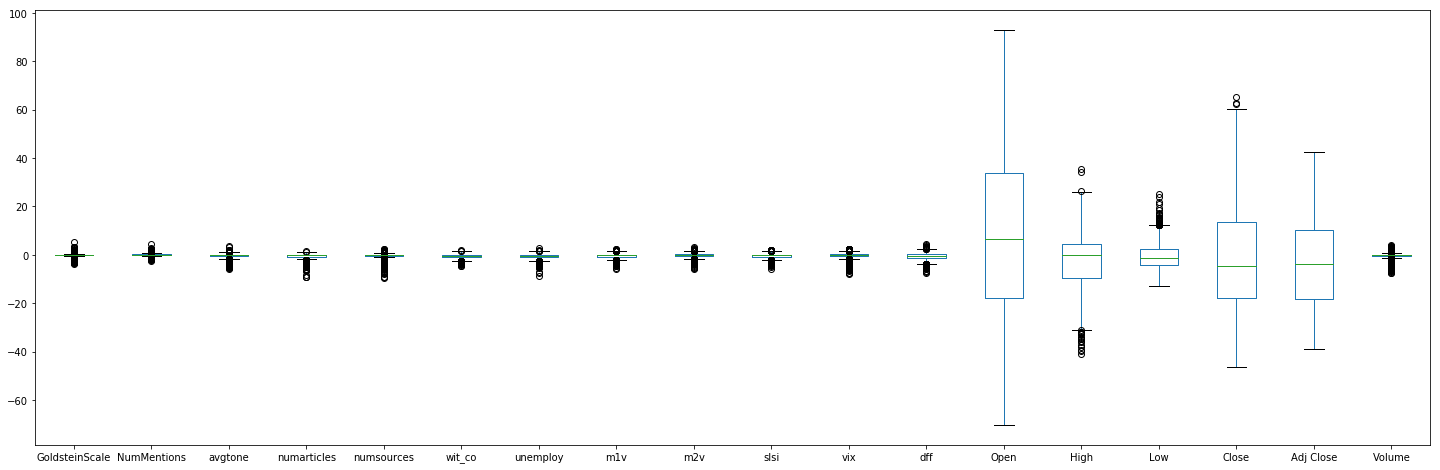

In [42]:
%pylab inline
pylab.rcParams['figure.figsize'] = (25, 8)
data = pd.DataFrame(s)
data.columns = X_train_df.columns
data.plot.box()


### Now we have positives and negatives so before we take the mean we want to take the abs before we take the mean in your code you were taking it after

In [43]:
## Using your code
mean_df = data.abs().mean()

In [44]:
mean_df.T.sort_values()

GoldsteinScale     0.264869
NumMentions        0.269504
numsources         0.502513
m2v                0.540100
avgtone            0.545747
Volume             0.585855
numarticles        0.616819
m1v                0.619760
slsi               0.643633
vix                0.657326
wit_co             0.693039
unemploy           0.756657
dff                1.061208
Low                3.911338
High               8.246509
Adj Close         14.772058
Close             17.435398
Open              27.238781
dtype: float32